# Project 3: Natural Language Processing of Subreddit Posts
------------------------------------------------------------

Project notebook organisation:
1. [Webscraping and Data Acquisition]()
2. [Exploratory Data Analysis and Preprocessing]()
3. **Model Tuning and Insights**(current notebook)

###  Contents:
  1. [Modeling](#Modeling)
  2. [Results & Analysis](#Results-&-Analysis)
  3. [Conclusion](#Conclusion)
  4. [Recommendations](#Recommendations)

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')
import re
%config InlineBackend.figure_format = 'retina'

# Enables Pandas to display all the columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Enables Pandas to display long strings properly
pd.options.display.max_colwidth = 100

# Modeling

In [2]:
df_cleaned = pd.read_csv('../data/df_model.csv')
# X and y are both Series
X = df_cleaned['tok_lemma_all_text']
y = df_cleaned['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42,
                                                  stratify=y)


Several models and confusion matrices were made based on different types of vectorizers and classifiers and obtain several metrics:

Vectorizers:

1. CountVectorizer (CVEC)
2. Term Frequency–Inverse Document Frequency Vectorizer (TFIDF)

Models/Classifiers:

1. Baseline Model
2. Multinomial Naive Bayes (NB)
3. Logistic Regression

Metrics:

1. Training/Testing Score
2. Accuracy
3. Misclassification
4. Sensitivity
5. Specificity
6. Precision
7. F1 Score

### Basic Model
The higher probability of 'subreddit' as the baseline. Obtaining the probability distribution, given a random text, choosing 'Investing' as the subreddit gives us a 49.7% chance of being correct. Hence, our baseline model is 49.7%.

In [3]:
df_cleaned['subreddit'].value_counts(normalize=True)

CryptoCurrency    0.502933
investing         0.497067
Name: subreddit, dtype: float64

In [4]:
# creating function to fit models, pipeline, hyperparameters and plotting.
def model(model_type):
    model_type.fit(X_train, y_train)
    model_preds = model_type.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, model_preds).ravel()
    print(f'Best Score:                                {model_type.best_score_}')
    print(f'Train Score:                               {model_type.score(X_train, y_train)}')
    print(f'Accuracy (Test Score):                     {((tp+tn)/(tn+fp+fn+tp))}')
    print(f'Misclassification:                         {(1-(tp+tn)/(tn+fp+fn+tp))}')
    print(f'Sensitivity / True Positive Rate / Recall: {((tp)/(tp+fn))}')
    print(f'Specificity / True Negative Rate:          {(tn/(tn+fp))}')
    print(f'Precision / Positive Predictive Value:     {(tp/(tp+fp))}')
    print(f'F1 Score:                                  {(2*(((tp)/(tp+fn))*(tp/(tp+fp))))/(((tp)/(tp+fn))+(tp/(tp+fp)))}')
    print(f'Best Parameters:                           {model_type.best_params_}')
    plot_confusion_matrix(model_type, 
                          X_test, y_test, 
                          cmap='Blues', 
                          values_format='d',
                          display_labels=['r/investing', 'r/CryptoCurrency']
                         );

## MultiNomial Naive Bayes
In this section, we create two Multinomial Naive Bayes models by using different vectorizers: CountVectorizer and TFIDF Vectorizer.

CountVectorizer Naive Bayes

 Pipeline and GridSearchCV were used to perform a CVEC Multinomial Naive Bayes model based on a range of parameters. Below, the range of parameters for respective features and the best parameter used were listed, as well as the Accuracy and other metrics results:

Best Score:                                0.9243788720700007
Train Score:                               0.953715775749674
Accuracy (Test Score):                     0.91015625
Misclassification:                         0.08984375
Sensitivity / True Positive Rate / Recall: 0.8661417322834646
Specificity / True Negative Rate:          0.9534883720930233
Precision / Positive Predictive Value:     0.9482758620689655
F1 Score:                                  0.9053497942386831
Best Parameters:                           {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 3)}


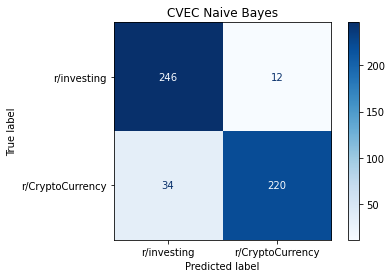

In [5]:
# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe_cvec_nb = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

pipe_cvec_nb_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

# Instantiate GridSearchCV.
gs_cvec_nb = GridSearchCV(
    estimator=pipe_cvec_nb, 
    param_grid=pipe_cvec_nb_params, 
    cv=5)

model(gs_cvec_nb)
plt.title('CVEC Naive Bayes');

### TF-IDF Vectorizer Naive Bayes

Pipeline and GridSearchCV were used to perform a TVEC Multinomial Naive Bayes model based on a range of parameters. Below, the range of parameters for respective features and the best parameter used were listed, as well as the Accuracy and other metrics results:

Best Score:                                0.9269911221817717
Train Score:                               0.9511082138200783
Accuracy (Test Score):                     0.908203125
Misclassification:                         0.091796875
Sensitivity / True Positive Rate / Recall: 0.8818897637795275
Specificity / True Negative Rate:          0.9341085271317829
Precision / Positive Predictive Value:     0.9294605809128631
F1 Score:                                  0.905050505050505
Best Parameters:                           {'tvec__max_features': 2000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


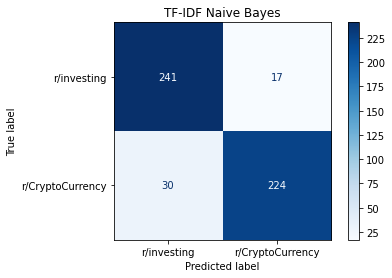

In [6]:
tvec = TfidfVectorizer()
nb = MultinomialNB()

# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_nb = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

pipe_tvec_nb_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]
}

# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(
    estimator=pipe_tvec_nb,
    param_grid=pipe_tvec_nb_params,
    cv=5)

model(gs_tvec_nb)
plt.title('TF-IDF Naive Bayes');

Comparing Naive Bayes Results

The best parameters found:

| Parameter  |  Best CVEC |  Best TVEC |
|---|---|---|
|Vectorizer Max Features |5000|  2000 |
|Vectorizer Ngram Range  |(1, 3)|(1, 3)|


Observations:

Both TVEC and Cvec model had used trigrams in addition to the unigrams and bigrams used in CVEC.

More features were used in the Cvec model, possibly due to the inclusion of trigrams.

Although more features were used in CVEC model, no negative impact on overfitting can be seen. 
Instead, using more features in combination with a trigram had provided greater predictive power.


### Observations from both naive bayes model

Overall, The naive bayes model gives us a favorable results on our 4 main metrics: Accuracy, Sensitivity, Specificity and Precision.
Based on results, a TF-IDF vectorizer had scored better on 3 out of 4 of our metrics.

Thus, TF-IDF vectorized naive bayes model performs better than a Count Vectorized naive bayes model.

Conclusion: Better Vectorizer: TVEC

## Logistic Regression
In this section, we create a logistic regression model using CVEC and TF-IDF Vectorizer and tabulate our findings. We first create a function to call on our models based on the format 'gs(vectorizer)\(model name)'

### CountVectorizer Logistic Regression
Pipeline and GridSearchCV were used to perform a CVEC logistic regression model based on a range of parameters. The range of parameters for respective features and the best parameter used were listed, as well as the Accuracy and other metrics results:

Best Score:                                0.9250196930020651
Train Score:                               0.9315514993481095
Accuracy (Test Score):                     0.908203125
Misclassification:                         0.091796875
Sensitivity / True Positive Rate / Recall: 0.905511811023622
Specificity / True Negative Rate:          0.9108527131782945
Precision / Positive Predictive Value:     0.9090909090909091
F1 Score:                                  0.9072978303747535
Best Parameters:                           {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'logit__cv': 10, 'logit__n_jobs': -1, 'logit__random_state': 42}


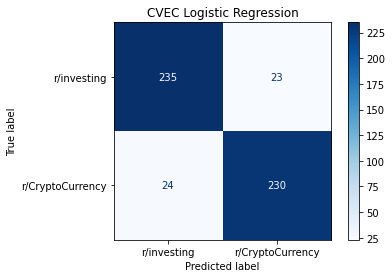

In [7]:
cvec = CountVectorizer()
logit = LogisticRegressionCV()

pipe_cvec_logit = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

pipe_cvec_logit_params = {
    'cvec__max_features': [1_000, 2_000, 3_000,
                            4_000, 5_000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [5, 10, 15, 20, 25]}

gs_cvec_logit = GridSearchCV(
    estimator=pipe_cvec_logit,
    param_grid=pipe_cvec_logit_params,
    cv=5)

model(gs_cvec_logit)
plt.title('CVEC Logistic Regression');

### TF-IDF Vectorizer Logistic Regression
Pipeline and GridSearchCV were used to perform a TVEC logistic regression model based on a range of parameters. The range of parameters for respective features and the best parameter used were listed, as well as the Accuracy and other metrics results:

Best Score:                                0.9380639117753506
Train Score:                               0.9582790091264668
Accuracy (Test Score):                     0.92578125
Misclassification:                         0.07421875
Sensitivity / True Positive Rate / Recall: 0.9173228346456693
Specificity / True Negative Rate:          0.9341085271317829
Precision / Positive Predictive Value:     0.932
F1 Score:                                  0.9246031746031745
Best Parameters:                           {'logit__cv': 5, 'logit__n_jobs': -1, 'logit__random_state': 42, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1)}


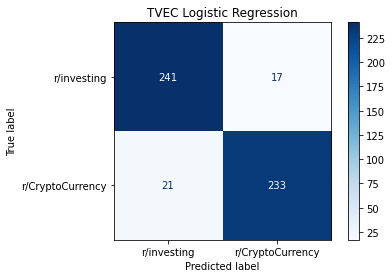

In [8]:
tvec = TfidfVectorizer()
logit = LogisticRegressionCV()

pipe_tvec_logit = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

pipe_tvec_logit_params = {
    'tvec__max_features': [	1000, 2000, 3000,
                            4000, 5000],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3),
                        (1, 4), (1, 5), (1, 6)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [5, 10, 15, 20, 25]
}

gs_tvec_logit = GridSearchCV(
    estimator=pipe_tvec_logit,
    param_grid=pipe_tvec_logit_params,
    cv=5)

model(gs_tvec_logit)
plt.title('TVEC Logistic Regression');

# Results and Analysis



Eliminate CVEC Models

Based on results in the earlier comparisons between CVEC and TVEC models, the TVEC model is more appropriate for use because the penalization of common words in through TF-IDF provides a greater weight on the focus words within the dataset. The focus words in turn provide greater predictive power than compared to simply counting word frequency as per CVEC. This leaves us with CVEC models.


Conclusions

The TVEC logistic regression will be selected predictive models to presented to due to the following factors:

Low overfitting to training data. Therefore, these models should perform better for blind data, such as when collecting new posts.
Highest specificity. As such, the selected model with the highest rates of specificity to ensure that we are not incorrectly spending funds.

# Conclusion

I conclude by stating our findings, and providing a recommendation based on my company's requirement.

In comparing parameters, I find that a higher parameter number does not automatically translate to a better result. This is due to the diminishing returns in predictive power of the parameters. Also, using an ngram range is better than using singular words only. This is because focus words often come in a phrase, similar to why supermarkets place soft drinks next to pizzas, or why casket-sellers also sell flowers. In all three cases, things which complement one another are often used consecutively.

In comparing models, a TF-IDF vectorized model provides a better predictive value than a Count Vectorized model. This is because while some stop words have been removed, there are still many stop words prevalent in the dataset. TF-IDF balances out the frequency of words used by penalizing common words which are not explicitly found in our stop words. This provides a higher weightage for non-stop words. Among the non-stop words, some of these are focus words used in the different subreddits due to their different focus.

In comparing our two best models, logistic regression model is preferred as compared to our naive bayes model. Two reasons for this: maximization of focus metric, and best overall balance in our 4 metrics. Our focus metric, specificity, performed best in a logistic regression. The highest specificity is desired in the models. In addition, the logistic regression scores over 90% on 3 out of 4 metrics, while specificity scores a hair below 90%, at 89.9%. Our naive bayes performed slightly poorly of 88%+ on sensitivity, but impressively for specificity and precision (93.4% and 93.2% respectively). As such, while an equally weighted result points to using a naive bayes model (93.8% vs 92.7%), I believe that a logistic regression would be more reliable overall.

# Recommendation
I recommend using our logistic regression model for reasons provided above. To improve our model, I suggest a few things that I can do in the future:

1. Expand data collection from other sources (not just Reddit).
2. Identifying more stop words to reduce noise in our data.
3. Creating a dictionary to process words more appropriately.
4. Obtain greater computing power or more time to process a greater number of hyperparameters.